In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime

# 1. Create fake data for 1 bunch 

In [3]:
sampling_frequency = 11245.5 # LHC revolution frequency
sampling_time      = 1./sampling_frequency 
nyquist_frequency  = sampling_frequency/2.
bunch_spacing      = 25e-9 # bunch spacing
total_nb_bunches   = 3564 # total number of bunches in the LHC

signal1_frequency  = 3000.    # Hz
signal1_amplitude  = 5.0     # assuming um
signal1_color      = 'r'
signal2_frequency  = 8000.    # Hz
signal2_amplitude  = 2.5 
signal2_color      = 'b'
signal3_frequency  = 16000.    # Hz
signal3_amplitude  = 1.0 
signal3_color      = 'g'

time               = np.arange(0, 1, 1/sampling_frequency) # signal of 1 sec. durtation

In [ ]:
signal = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*time)

signal_fft = abs(np.fft.fft(signal))
signal_fft = signal_fft/len(signal_fft)*2. # normalization
signal_freqs = np.linspace(0, sampling_frequency, len(time))

In [4]:
def get_aliased_frequency(freq):
    while freq > sampling_frequency / 2:
        freq = abs(sampling_frequency-freq)
    return freq

3000.0 will appear as 3000.0 Hz, r
8000.0 will appear as 3245.5 Hz, b
16000.0 will appear as 4754.5 Hz, g


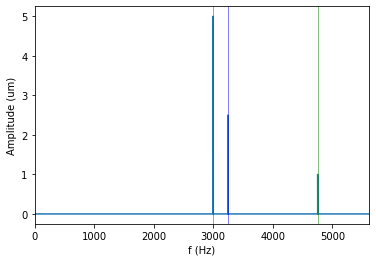

In [5]:
fig, ax = plt.subplots()
plt.plot(signal_freqs, signal_fft)
plt.xlim(0, nyquist_frequency)
plt.ylabel("Amplitude (um)")
plt.xlabel("f (Hz)")

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    # find aliased frequencies if any
    aliased_frequency = get_aliased_frequency(freq)
    print(f"{freq} will appear as {aliased_frequency} Hz, {color}")
    plt.axvline(aliased_frequency, c=color, lw=0.5)
    

# 2. Create fake data for several bunches

## Periodic filling scheme

In [3]:
# periodc filling scheme

nb_bunches = 3
deltaT_s   = total_nb_bunches/nb_bunches * bunch_spacing 
signal_freqs = np.linspace(0, sampling_frequency, len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = nb_bunch * deltaT_s
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs*time_delay))

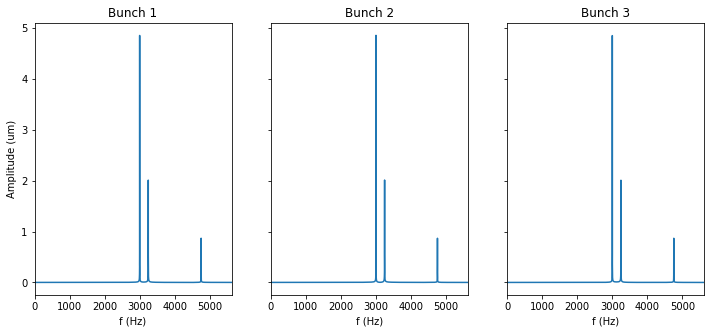

In [4]:
fig, ax = plt.subplots(figsize=(12,5), ncols=3, sharex=True, sharey=True)

plt.xlim(0, nyquist_frequency)
plt.sca(ax[0])
plt.ylabel("Amplitude (um)")

for nb_bunch in range(nb_bunches):
    plt.sca(ax[nb_bunch])
    plt.xlabel("f (Hz)")
    plt.plot(signal_freqs,abs(fft_bunch[nb_bunch]))
    plt.title(f"Bunch {nb_bunch+1}")




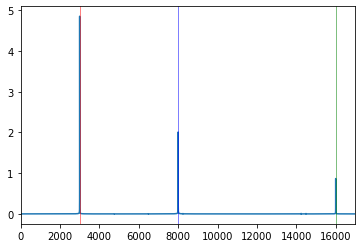

In [5]:
nb_bunches = 3
filling_pattern = [0, 1*total_nb_bunches/3, 2*total_nb_bunches/3]
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




## Half-full machine

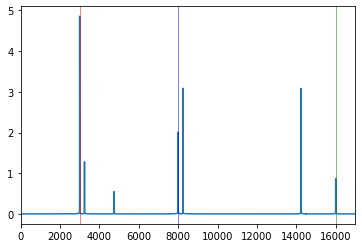

In [10]:
nb_bunches = total_nb_bunches//2
filling_pattern = np.arange(0, nb_bunches)
signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    #print(nb_bunch)
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)



## Random filling scheme

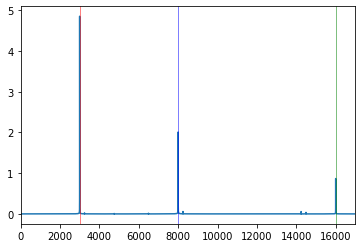

In [12]:
import random

nb_bunches = 2000

filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)




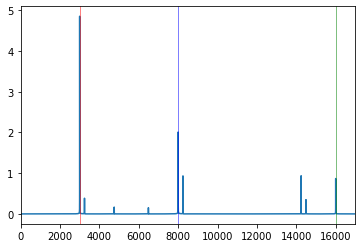

In [18]:
import random

nb_bunches = 50

filling_pattern = random.sample(range(total_nb_bunches+1), nb_bunches)

signal_freqs = np.linspace(0, sampling_frequency, len(time))

repeat_fft = 3
signal_freqs_extended = np.linspace(0, sampling_frequency*repeat_fft, repeat_fft*len(time))

signal_bunch = {}
fft_bunch = {}
combined_fft_bunch_corrected = []

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    signal_bunch[nb_bunch] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    fft_bunch[nb_bunch] = np.fft.fft(signal_bunch[nb_bunch])
    fft_bunch[nb_bunch]/= len(fft_bunch[nb_bunch]) # no abs
    fft_bunch[nb_bunch]*= 2.0
    
    fft_bunch[nb_bunch] = np.concatenate([fft_bunch[nb_bunch]]*repeat_fft)
    combined_fft_bunch_corrected.append(fft_bunch[nb_bunch] * np.exp(-1j*2*np.pi*signal_freqs_extended*time_delay))

combined_fft = np.mean(combined_fft_bunch_corrected, axis=0)
plt.plot(signal_freqs_extended, abs(combined_fft))
plt.xlim(0, 17000)

for freq, color in zip([signal1_frequency, signal2_frequency, signal3_frequency], [signal1_color, signal2_color, signal3_color]):
    plt.axvline(freq, c=color, lw=0.5)





# 3. Fake data in h5 format and ADT class

In [4]:
# Create a 2D array with # number of turns as rows and 3564 column 

nb_bunches = 3
filling_pattern = [0, 1*total_nb_bunches//3, 2*total_nb_bunches//3]

fake_data = np.zeros((len(time), total_nb_bunches), dtype='float')

for nb_bunch in range(nb_bunches):
    time_delay = filling_pattern[nb_bunch] * bunch_spacing
    bunch_time = time + time_delay
    fake_data[:, filling_pattern[nb_bunch]] = signal1_amplitude*np.cos(2*np.pi*signal1_frequency*bunch_time) + signal2_amplitude* np.cos(2*np.pi*signal2_frequency*bunch_time) + signal3_amplitude* np.cos(2*np.pi*signal3_frequency*bunch_time)
    
# Save in h5 format compatible with ADTObsBox data
with h5py.File('B1H_Q8_20250618_04h00m05s26426us.h5','w') as f:
    group = f.create_group('B1')
    group.create_dataset(name='horizontal', data=fake_data)

with h5py.File('B1H_Q8_20250618_04h01m05s26426us.h5','w') as f:
    group = f.create_group('B1')
    group.create_dataset(name='horizontal', data=fake_data)
    
with h5py.File('B2H_Q7_20250618_04h04m05s26426us.h5','w') as f:
    group = f.create_group('B2')
    group.create_dataset(name='horizontal', data=fake_data)

filenames_to_consider = ["B1H_Q8_20250618_04h00m05s26426us.h5", "B1H_Q8_20250618_04h01m05s26426us.h5", 'B2H_Q7_20250618_04h04m05s26426us.h5']


In [9]:
class ADT:
    def __init__(self, filenames):
        df = self.extract_file_info(filenames)
        df.sort_index(inplace=True)
        self.importEmptyDF = {bp: df[df['Beam-Plane'] == bp] for bp in np.unique(df['Beam-Plane'])}

    def extract_file_info(self, filenames):
        beam_planes = []
        pus = []
        times = []
        for file_name in filenames:
            bp, pu, date, time = file_name.split('/')[-1].split('_')
            time = self.fromName2Timestamp(f'{bp}_{pu}_{date}_{time}')
            beam_planes.append(bp)
            pus.append(pu)
            times.append(time)
        return pd.DataFrame({'PU': pus, 'Beam-Plane': beam_planes, 'Path': filenames}, index=np.array(times))

    def fromName2Timestamp(self, current_fileName,tz_start='CET',tz_end='UTC'):
        year = current_fileName.split('_')[-2][0:4]
        month = current_fileName.split('_')[-2][4:6]
        day   = current_fileName.split('_')[-2][6:]
        full_datetime = f'{day}/{month}/{year} ' + current_fileName.split('_')[-1].split('.')[0]
        return pd.Timestamp(datetime.datetime.strptime(full_datetime,"%d/%m/%Y %Hh%Mm%Ss%fus")).tz_localize(tz_start, ambiguous=False).tz_convert(tz_end)

    def loadData(self, fileName):
        fi = h5py.File(fileName, 'r')
        beam, plane = fileName.split('_')[-4].split('/')[-1][:2], fileName.split('_')[-4].split('/')[-1][2:3]
        plane = 'horizontal' if plane == 'H' else 'vertical'
        alldat = fi[beam][plane]
        print('Buffer: Turns = %s, Bunches = %s' % (alldat.shape[0], alldat.shape[1]))
        return alldat[:]
    
    def cmp_fft(self, data, specific_bunch, frev=11245.5, first_bunch_slot=0, bunch_spacing=25e-9, repeat_fft=1):
        fourier =  np.fft.fft(data[:,specific_bunch] )
        fourier = fourier/len(fourier)*2.0
        delay   = (specific_bunch-first_bunch_slot)*bunch_spacing
        fourier = np.concatenate([fourier]*repeat_fft)
        freqs   = np.linspace(0, frev*repeat_fft, len(fourier))
        corrected_fourier = fourier*np.exp(-1j*2.0*np.pi*freqs*delay)
        return pd.Series([freqs, fourier.real, fourier.imag, corrected_fourier.real, corrected_fourier.imag])
    

In [10]:
#from useful_tools.useful_functions import *

B1H B1
Buffer: Turns = 11246, Bunches = 3564
Buffer: Turns = 11246, Bunches = 3564
Bunch slots [   0 1188 2376]
Bunch slots [   0 1188 2376]
B2H B2
Buffer: Turns = 11246, Bunches = 3564
Bunch slots [   0 1188 2376]


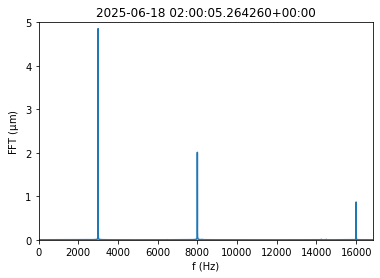

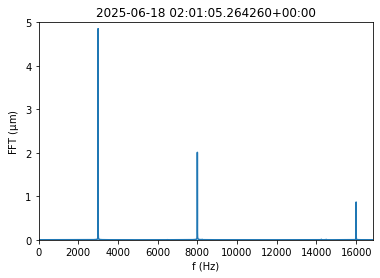

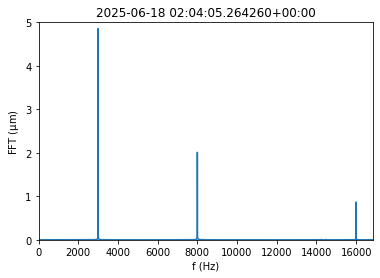

In [11]:
adt = ADT(filenames_to_consider)
myDict = adt.importEmptyDF

fourier_tot_real, fourier_tot_imag, fourier_tot_real_corr, fourier_tot_imag_corr, bunch_number_tot, time_tot, pu_tot, beam_plane_tot = [], [], [], [], [], [], [], []

repeat_fft = 3
frev = 11245.5
which_bunch_b1 = 'all'
which_bunch_b2 = 'all'

for beamplane in myDict.keys():
    print(beamplane, beamplane[0:2])
    myDF = myDict[beamplane].copy()
            
    #try:
    if True:
        myDF['Data'] = myDF['Path'].apply(adt.loadData)
      
        for counter in range(len(myDF)):
            data = myDF.iloc[counter]['Data']
            time = myDF.iloc[counter].name
            pu   = myDF.iloc[counter].PU
            current_beamplane = myDF.iloc[counter]['Beam-Plane']
            # for each bunch

            if beamplane[0:2] == 'B1':
                if which_bunch_b1 =='all':
                   idx = np.where(abs(data[0,:])>0.0)[0]
                else:
                    idx = which_bunch_b1

            elif beamplane[0:2] == 'B2':
                if which_bunch_b2 =='all':
                   idx = np.where(abs(data[0,:])>0.0)[0]
                else:
                    idx = which_bunch_b2
            
            print(f"Bunch slots {idx}")
            for idd in idx:
              #try:
              if True:

    
                freqs, fourier_real, fourier_imag, fourier_corr_real, fourier_corr_imag  = adt.cmp_fft(data, specific_bunch=idd, frev=frev, first_bunch_slot=idx[0], bunch_spacing=25e-9, repeat_fft=repeat_fft)
                
                fourier_tot_real.append(fourier_real)
                fourier_tot_imag.append(fourier_imag)
                fourier_tot_real_corr.append(fourier_corr_real)
                fourier_tot_imag_corr.append(fourier_corr_imag)
                
                bunch_number_tot.append(idd)
                time_tot.append(time)
                #freqs_tot.append(freqs)
                pu_tot.append(pu)
                beam_plane_tot.append(current_beamplane) 
              #except:
              #  print('prob') 
    #except:
    #    print('prob, load_data')

dff = pd.DataFrame({'fourier_corr_real': fourier_tot_real_corr, "fourier_corr_imag": fourier_tot_imag_corr,'fourier_real': fourier_tot_real, 'fourier_imag': fourier_tot_imag,  'bunch': bunch_number_tot, 'time': time_tot, 'beam-plane': beam_plane_tot, 'pu': pu_tot})


for key, group in dff.groupby("time"):
    aux = group.apply(lambda x: x.fourier_corr_real + 1j*x.fourier_corr_imag, axis=1).mean()
    
    freqs = np.linspace(0, 11245.5*repeat_fft, len(aux))
    fig, ax = plt.subplots()
    plt.plot(freqs, abs(aux)) 
    plt.xlabel("f (Hz)")
    plt.ylabel(r"FFT ($\rm \mu m$)")
    plt.title(key)
    plt.ylim(0,5.0)
    plt.xlim(0, frev*repeat_fft*0.5)
    